In [2]:
import pandas as pd
import openai
import time
import re
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import mean_absolute_error
import pickle
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
import datetime 
import sys
sys.path.append('../experiment_01')
from sidemethods import logprobs_from_prompt, proc, proc_lower, prob_of_ending
import torch
import random
# import benjamin-hochberg
from statsmodels.stats.multitest import multipletests

In [18]:
def make_bar_plots_gibbs(model_result_dict_3, model_result_dict_4, title):
    # Visualize results as bar charts with 2 bars per key (one for each experiment) and each bar being the correlation coefficient
    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.xlabel("Image Schema")
    plt.ylabel("Spearman Correlation Coefficient")
    # set y axis to 0.0 to 1.0
    plt.ylim(0.0, 1.0)
    # set y ticks to 0.0, 0.2, 0.4, ..., 1.0
    plt.yticks(np.arange(0.0, 1.1, 0.2))
    for key in DEFINITIONS:
        # the bars of the two experiments are next to each other
        plt.bar(key, stats.spearmanr(model_result_dict_3[key], exp_3_df[key])[0], width=0.4, color='orange')
        # move the bar to the right
        plt.bar(key, stats.spearmanr(model_result_dict_4[key], exp_4_df[key])[0], width=0.4, align='edge', color='blue')
    plt.legend(["Experiment 3", "Experiment 4"])
    plt.grid(axis='y')
    plt.show()

def make_bar_plots_beitel(model_result_dict_2, title):
    # Visualize results as bar charts with 2 bars per key (one for each experiment) and each bar being the correlation coefficient
    plt.figure(figsize=(12, 4))
    plt.title(title)
    plt.xlabel("Image Schema")
    plt.ylabel("Spearman Correlation Coefficient")
    # set y axis to 0.0 to 1.0
    plt.ylim(0.0, 1.0)
    # set y ticks to 0.0, 0.2, 0.4, ..., 1.0
    plt.yticks(np.arange(0.0, 1.1, 0.2))
    for key in DEFINITIONS_2:
        # the bars of the two experiments are next to each other
        plt.bar(key, stats.spearmanr(model_result_dict_2[key], exp_2_df[key])[0], width=0.4, color='red')
        # move the bar to the right
    plt.legend(["Experiment 2"])
    plt.grid(axis='y')
    plt.show()

def make_bar_plots_all(model_result_dict_2, model_result_dict_3, model_result_dict_4, title):
    # exp2 has different keys than exp3 and exp4
    # Visualize results as bar charts with 3 bars per xtick, the x labels being the image schemas and the bars being the correlation coefficient
    plt.figure(figsize=(16, 5))
    plt.title(title)
    plt.xlabel("Image Schema")
    plt.ylabel("Spearman Correlation Coefficient")
    # set y axis to 0.0 to 1.0
    plt.ylim(0.0, 1.0)
    # set y ticks to 0.0, 0.2, 0.4, ..., 1.0
    plt.yticks(np.arange(0.0, 1.1, 0.2))
    for i, key in enumerate(DEFINITIONS_2):
        # the bars of the two experiments are next to each other
        plt.bar(i-0.25, stats.spearmanr(model_result_dict_2[key], exp_2_df[key])[0], width=0.25, color='red')
    for i, key in enumerate(DEFINITIONS):
        # move the bar to the right
        plt.bar(i, stats.spearmanr(model_result_dict_3[key], exp_3_df[key])[0], width=0.25, color='orange')
        # move the bar to the right
        plt.bar(i+0.25, stats.spearmanr(model_result_dict_4[key], exp_4_df[key])[0], width=0.25, color='blue')
    # change x labels to image schema names
    labels = []
    for key in DEFINITIONS_2:
        labels.append(key)
    for j, key in enumerate(DEFINITIONS):
        labels[j]+= "/" + key
    plt.xticks(np.arange(len(labels)), labels)
    # add grid
    plt.grid(axis='y')


def make_scatter_plots_beitel(model_result_dict_2, title):
    # plot side by side, 5 plots
    fig, axs = plt.subplots(1, 5, figsize=(20, 3))
    fig.suptitle(title)
    plt.tight_layout()
    # add space between title and plots
    #fig.subplots_adjust(top=0.2)
    for i, key in enumerate(DEFINITIONS_2):
        # add scatter plot
        axs[i].scatter(model_result_dict_2[key], exp_2_df[key], color='red')
        axs[i].set_title(key)
        if i==0: axs[i].set_ylabel("Human Rating (Exp 2)")
        axs[i].set_xlabel("GPT Rating")
        # set x and y limits to 0 to 7.2
        axs[i].set_xlim(0.7, 7.2)
        axs[i].set_ylim(0.7, 7.2)
        # set x and y ticks to 0, 1, 2, ..., 7
        axs[i].set_xticks(np.arange(1, 8, 1))
        axs[i].set_yticks(np.arange(1, 8, 1))
        # add correlation coefficient to each plot
        axs[i].text(0.05, 0.95, "r = " + str(round(stats.spearmanr(model_result_dict_2[key], exp_2_df[key])[0], 2)), transform=axs[i].transAxes, fontsize=12, verticalalignment='top')

def make_scatter_plots_gibbs(model_result_dict_3, model_result_dict_4, title):
    # plot side by side, 5 plots
    fig, axs = plt.subplots(2, 5, figsize=(20, 6))
    fig.suptitle(title)
    for i, key in enumerate(DEFINITIONS):
        axs[0, i].scatter(model_result_dict_3[key], exp_3_df[key], color='orange')
        axs[0, i].set_title(key)
        if i==0: axs[0, i].set_ylabel("Human Rating (Exp 3)")
        axs[1, i].scatter(model_result_dict_4[key], exp_4_df[key], color='blue')
        axs[1, i].set_xlabel("GPT Rating")
        if i ==0: axs[1, i].set_ylabel("Human Rating (Exp 4)")
        # set x and y limits to 0 to 7.2
        axs[0, i].set_xlim(0.7, 7.2)
        axs[0, i].set_ylim(0.7, 7.2)
        axs[1, i].set_xlim(0.7, 7.2)
        axs[1, i].set_ylim(0.7, 7.2)
        # set x and y ticks to 0, 1, 2, ..., 7
        axs[0, i].set_xticks(np.arange(1, 8, 1))
        axs[0, i].set_yticks(np.arange(1, 8, 1))
        axs[1, i].set_xticks(np.arange(1, 8, 1))
        axs[1, i].set_yticks(np.arange(1, 8, 1))
        # add correlation coefficient to each plot
        axs[0, i].text(0.05, 0.95, "r = " + str(round(stats.spearmanr(model_result_dict_3[key], exp_3_df[key])[0], 2)), transform=axs[0, i].transAxes, fontsize=12, verticalalignment='top')
        axs[1, i].text(0.05, 0.95, "r = " + str(round(stats.spearmanr(model_result_dict_4[key], exp_4_df[key])[0], 2)), transform=axs[1, i].transAxes, fontsize=12, verticalalignment='top')

def print_correlations(completions_clean, exp_df, correlation_type, name=""):
    all_p_values = []
    all_r_values = []
    if correlation_type == "spearman":
        print("Spearman correlations per IS:")
        for k in completions_clean:
            all_r_values.append(stats.spearmanr(completions_clean[k], exp_df[k])[0])
            all_p_values.append(stats.spearmanr(completions_clean[k], exp_df[k])[1])
    elif correlation_type == "pearson":
        print("Pearson correlations per IS:")
        for k in completions_clean:
            all_r_values.append(stats.pearsonr(completions_clean[k], exp_df[k])[0])
            all_p_values.append(stats.pearsonr(completions_clean[k], exp_df[k])[1])
    # correct p values using bonferroni-holm
    corrected_p_values = multipletests(all_p_values, alpha=0.05, method='holm')[1] 
    for i,k in enumerate(completions_clean):
        print(k[:12], "\tp-value:", round(all_p_values[i],3), "\tcorrelation:", round(all_r_values[i],3))#, "corrected p-value:", corrected_p_values[i]) 


def add_p_values_to_list(completions_clean, exp_df, correlation_type, all_p_values, all_r_values, labels, name, ignore_nan):
    if correlation_type == "spearman":
        for k in completions_clean:
            r, p = stats.spearmanr(completions_clean[k], exp_df[k])
            # check for nan
            if np.isnan(p) and not ignore_nan:
                p = 1.0
                all_r_values.append(r)
                all_p_values.append(p)
                labels.append(name+"_"+k[:12])
            if not np.isnan(p):
                all_r_values.append(r)
                all_p_values.append(p)
                labels.append(name+"_"+k[:12])
    elif correlation_type == "pearson":
        for k in completions_clean:
            r, p = stats.pearsonr(completions_clean[k], exp_df[k])
            # check for nan
            if np.isnan(p) and not ignore_nan:
                p = 1.0
                all_r_values.append(r)
                all_p_values.append(p)
                labels.append(name+"_"+k[:12])
            if not np.isnan(p):
                all_r_values.append(r)
                all_p_values.append(p)
                labels.append(name+"_"+k[:12])
    return all_p_values, all_r_values, labels            
    
    

def get_mean_absolute_error(completions, exp_df):
    print("The mean absolute error for each image schema is: ")
    errs = []
    for key in completions:
        print(key, mean_absolute_error(completions[key], exp_df[key]))
        errs.append(mean_absolute_error(completions[key], exp_df[key]))
    print("The mean absolute error for all image schemas is: ", np.mean(errs))

# Load Data

In [4]:
exp_2_df = pd.read_csv('../../data/Beitel_Exp2.csv', sep=';')
exp_3_df = pd.read_csv('../../data/Gibbs_Exp3.csv', sep=';')
# drop nan rows
exp_3_df = exp_3_df.dropna()
exp_4_df = pd.read_csv('../../data/Gibbs_Exp4.csv', sep=';')
STIMULI_EXP2 = exp_2_df['Stimulus'].values
STIMULI_EXP3 = exp_3_df['Stimulus'].values
STIMULI_EXP4 = exp_4_df['Stimulus'].values
print(len(STIMULI_EXP2))
print(len(STIMULI_EXP3))
print(len(STIMULI_EXP4))

DEFINITIONS = {
    "VERTICALITY": "Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.",
    "BALANCE": "Consider the notion of BALANCE. Balance refers to your sense of symmetry or stability relative to some point within your body.",
    "CENTER-PERIPHERY": "Consider the notion of CENTER-PERIPHERY. Center-periphery refers to the experience of some objects or events as central while surrounding objects and events are peripheral or to the outside.",
    "LINKAGE": "Consider the notion of LINKAGE. Linkage refers to the perception of a connection between objects or events.",
    "RESISTANCE": "Consider the notion of RESISTANCE. Resistance refers to the experience of your body opposing some external force."
}

DEFINITIONS_2_INTRO='In the case of the use of "on" in "the book is on the desk":'
DEFINITIONS_2 = {
    "SUPPORT": "the SUPPORT relation refers to the desk supporting the book.",
    "PRESSURE": "the PRESSURE relation refers to the book exerting some pressure on the desk.",
    "CONSTRAINT": "the CONSTRAINT relation refers to the desk constraining the possible motions of the book.",
    "COVERING": "the COVERING relation refers to the book concealing the part of the desk that is under the book.",     # TODO:";" changed to "."
    "VISIBILITY": "the VISIBILITY relation refers to the book being visible on the desk."
}

37
32
32


In [5]:
# load model completion data

# davinci003
davinci003_exp2_df = pd.read_csv('lm_generations/df_single_prompt_exp2_davinci003_2023-10-19.csv')
davinci003_exp2_dict = {key: davinci003_exp2_df[key].values for key in ["SUPPORT", "PRESSURE", "CONSTRAINT", "COVERING", "VISIBILITY"]}

davinci003_exp3_df = pd.read_csv('lm_generations/df_single_prompt_exp3_davinci003_2023-10-18.csv')
davinci003_exp3_dict = {key: davinci003_exp3_df[key].values for key in ["VERTICALITY", "BALANCE", "CENTER-PERIPHERY", "LINKAGE", "RESISTANCE"]}

davinci003_exp4_df = pd.read_csv('lm_generations/df_single_prompt_exp4_davinci003_2023-10-18.csv')
davinci003_exp4_dict = {key: davinci003_exp4_df[key].values for key in ["VERTICALITY", "BALANCE", "CENTER-PERIPHERY", "LINKAGE", "RESISTANCE"]}

# davinci003 with logprobs
davinci003_exp2_df_logprobs = pd.read_csv('lm_generations/df_single_prompt_exp2_davinci003_logprobs_2023-10-19.csv')
davinci003_exp2_dict_logprobs = {key: davinci003_exp2_df_logprobs[key].values for key in ["SUPPORT", "PRESSURE", "CONSTRAINT", "COVERING", "VISIBILITY"]}

davinci003_exp3_df_logprobs = pd.read_csv('lm_generations/df_single_prompt_exp3_davinci003_logprobs_2023-10-18.csv')
davinci003_exp3_dict_logprobs = {key: davinci003_exp3_df_logprobs[key].values for key in ["VERTICALITY", "BALANCE", "CENTER-PERIPHERY", "LINKAGE", "RESISTANCE"]}

davinci003_exp4_df_logprobs = pd.read_csv('lm_generations/df_single_prompt_exp4_davinci003_logprobs_2023-10-18.csv')
davinci003_exp4_dict_logprobs = {key: davinci003_exp4_df_logprobs[key].values for key in ["VERTICALITY", "BALANCE", "CENTER-PERIPHERY", "LINKAGE", "RESISTANCE"]}

# davinci002
davinci002_exp2_df = pd.read_csv('lm_generations/df_single_prompt_exp2_davinci002_2023-11-04.csv')
davinci002_exp2_dict = {key: davinci002_exp2_df[key].values for key in ["SUPPORT", "PRESSURE", "CONSTRAINT", "COVERING", "VISIBILITY"]}

davinci002_exp3_df = pd.read_csv('lm_generations/df_single_prompt_exp3_davinci-002_2023-11-04.csv')
davinci002_exp3_dict = {key: davinci002_exp3_df[key].values for key in ["VERTICALITY", "BALANCE", "CENTER-PERIPHERY", "LINKAGE", "RESISTANCE"]}

davinci002_exp4_df = pd.read_csv('lm_generations/df_single_prompt_exp4_davinci-002_2023-11-04.csv', sep=';')
davinci002_exp4_dict = {key: davinci002_exp4_df[key].values for key in ["VERTICALITY", "BALANCE", "CENTER-PERIPHERY", "LINKAGE", "RESISTANCE"]}

# davinci 002 with logprobs

davinci002_exp3_df_logprobs = pd.read_csv('lm_generations/df_single_prompt_exp3_davinci-002_logprobs_2023-11-04.csv')
davinci002_exp3_dict_logprobs = {key: davinci002_exp3_df_logprobs[key].values for key in ["VERTICALITY", "BALANCE", "CENTER-PERIPHERY", "LINKAGE", "RESISTANCE"]}

# gpt-4

gpt4_exp2_df = pd.read_csv('lm_generations/df_single_prompt_exp2_gpt-4_2023-11-04.csv')
gpt4_exp2_dict = {key: gpt4_exp2_df[key].values for key in ["SUPPORT", "PRESSURE", "CONSTRAINT", "COVERING", "VISIBILITY"]}

gpt4_exp3_df = pd.read_csv('lm_generations/df_single_prompt_exp3_gpt-4_2023-11-04.csv')
gpt4_exp3_dict = {key: gpt4_exp3_df[key].values for key in ["VERTICALITY", "BALANCE", "CENTER-PERIPHERY", "LINKAGE", "RESISTANCE"]}

gpt4_exp4_df = pd.read_csv('lm_generations/df_single_prompt_exp4_gpt-4_2023-11-04.csv')
gpt4_exp4_dict = {key: gpt4_exp4_df[key].values for key in ["VERTICALITY", "BALANCE", "CENTER-PERIPHERY", "LINKAGE", "RESISTANCE"]}

# llama7b
llama7b_exp2_df = pd.read_csv('lm_generations/df_single_prompt_exp2_llama7-chat_2023-11-19.csv')
llama7b_exp2_dict = {key: llama7b_exp2_df[key].values for key in ["SUPPORT", "PRESSURE", "CONSTRAINT", "COVERING", "VISIBILITY"]}

llama7b_exp3_df = pd.read_csv('lm_generations/df_single_prompt_exp3_llama7-chat_2023-11-19.csv')
llama7b_exp3_dict = {key: llama7b_exp3_df[key].values for key in ["VERTICALITY", "BALANCE", "CENTER-PERIPHERY", "LINKAGE", "RESISTANCE"]}

llama7b_exp4_df = pd.read_csv('lm_generations/df_single_prompt_exp4_llama7-chat_2023-11-19.csv')
llama7b_exp4_dict = {key: llama7b_exp4_df[key].values for key in ["VERTICALITY", "BALANCE", "CENTER-PERIPHERY", "LINKAGE", "RESISTANCE"]}

# llama 13b
llama13b_exp2_df = pd.read_csv('lm_generations/df_single_prompt_exp2_llama13-chat_2023-11-19.csv')
llama13b_exp2_dict = {key: llama13b_exp2_df[key].values for key in ["SUPPORT", "PRESSURE", "CONSTRAINT", "COVERING", "VISIBILITY"]}

llama13b_exp3_df = pd.read_csv('lm_generations/df_single_prompt_exp3_llama13-chat_2023-11-19.csv')
llama13b_exp3_dict = {key: llama13b_exp3_df[key].values for key in ["VERTICALITY", "BALANCE", "CENTER-PERIPHERY", "LINKAGE", "RESISTANCE"]}

llama13b_exp4_df = pd.read_csv('lm_generations/df_single_prompt_exp4_llama13-chat_2023-11-19.csv')
llama13b_exp4_dict = {key: llama13b_exp4_df[key].values for key in ["VERTICALITY", "BALANCE", "CENTER-PERIPHERY", "LINKAGE", "RESISTANCE"]}

# llama 70b
llama70b_exp2_df = pd.read_csv('lm_generations/df_single_prompt_exp2_llama70-chat_2023-11-23.csv')
llama70b_exp2_dict = {key: llama70b_exp2_df[key].values for key in ["SUPPORT", "PRESSURE", "CONSTRAINT", "COVERING", "VISIBILITY"]}

llama70b_exp3_df = pd.read_csv('lm_generations/df_single_prompt_exp3_llama70-chat_2023-11-23.csv')
llama70b_exp3_dict = {key: llama70b_exp3_df[key].values for key in ["VERTICALITY", "BALANCE", "CENTER-PERIPHERY", "LINKAGE", "RESISTANCE"]}

llama70b_exp4_df = pd.read_csv('lm_generations/df_single_prompt_exp4_llama70-chat_2023-11-23.csv')
llama70b_exp4_dict = {key: llama70b_exp4_df[key].values for key in ["VERTICALITY", "BALANCE", "CENTER-PERIPHERY", "LINKAGE", "RESISTANCE"]}

# Analyse Data

## Logprob vs Max

In [6]:
# how big is the difference when using logprob averaging?
print("\nExperiment 2 — Beitel:")
get_mean_absolute_error(davinci003_exp2_dict, davinci003_exp2_dict_logprobs)
print("\nExperiment 3 — Gibbs Stand:")
get_mean_absolute_error(davinci003_exp3_dict, davinci003_exp3_dict_logprobs)
print("\nExperiment 4 — Gibbs Syonnym:")
get_mean_absolute_error(davinci003_exp4_dict, davinci003_exp4_dict_logprobs)


Experiment 2 — Beitel:
The mean absolute error for each image schema is: 
SUPPORT 0.5474568620338988
PRESSURE 0.4206053416524155
CONSTRAINT 0.3769131011273762
COVERING 0.23106340288452404
VISIBILITY 0.44818815163176273
The mean absolute error for all image schemas is:  0.4048453718659955

Experiment 3 — Gibbs Stand:
The mean absolute error for each image schema is: 
VERTICALITY 0.25352565197994803
BALANCE 0.3375683414003554
CENTER-PERIPHERY 0.5833259490262679
LINKAGE 0.3445448829863865
RESISTANCE 0.3778412002022125
The mean absolute error for all image schemas is:  0.3793612051190341

Experiment 4 — Gibbs Syonnym:
The mean absolute error for each image schema is: 
VERTICALITY 0.3098702671255624
BALANCE 0.3721755113682907
CENTER-PERIPHERY 0.5968953036838861
LINKAGE 0.2982509853946872
RESISTANCE 0.3250758973405232
The mean absolute error for all image schemas is:  0.38045359298258996


## Correlations

all with corrections

In [22]:
all_p_values_beitel = []
all_r_values_beitel = []
p_value_labels_beitel = []
all_p_values_gibbs = []
all_r_values_gibbs = []
p_value_labels_gibbs = []
ignore_nan = False



# beitel (exp2)
add_p_values_to_list(completions_clean=davinci002_exp2_dict, exp_df=exp_2_df, correlation_type="spearman", all_p_values=all_p_values_beitel, all_r_values=all_r_values_beitel, labels=p_value_labels_beitel, name="beitel_davinci002", ignore_nan=ignore_nan)
add_p_values_to_list(completions_clean=davinci003_exp2_dict, exp_df=exp_2_df, correlation_type="spearman", all_p_values=all_p_values_beitel, all_r_values=all_r_values_beitel, labels=p_value_labels_beitel, name="beitel_davinci003", ignore_nan=ignore_nan)
add_p_values_to_list(completions_clean=gpt4_exp2_dict, exp_df=exp_2_df, correlation_type="spearman", all_p_values=all_p_values_beitel, all_r_values=all_r_values_beitel, labels=p_value_labels_beitel, name="beitel_gpt4", ignore_nan=ignore_nan)
#add_p_values_to_list(completions_clean=llama7b_exp2_dict, exp_df=exp_2_df, correlation_type="spearman", all_p_values=all_p_values_beitel, all_r_values=all_r_values_beitel, labels=p_value_labels_beitel, name="beitel_llama7b", ignore_nan=ignore_nan)
add_p_values_to_list(completions_clean=llama13b_exp2_dict, exp_df=exp_2_df, correlation_type="spearman", all_p_values=all_p_values_beitel, all_r_values=all_r_values_beitel, labels=p_value_labels_beitel, name="beitel_llama13b", ignore_nan=ignore_nan)
add_p_values_to_list(completions_clean=llama70b_exp2_dict, exp_df=exp_2_df, correlation_type="spearman", all_p_values=all_p_values_beitel, all_r_values=all_r_values_beitel, labels=p_value_labels_beitel, name="beitel_llama70b", ignore_nan=ignore_nan)

# fdr benjamini hochberg
significant_results = 0
all_p_values_beitel_corrected = multipletests(all_p_values_beitel, alpha=0.05, method='fdr_bh')
for i,k in enumerate(p_value_labels_beitel):
    if all_p_values_beitel_corrected[1][i] < 0.05:
        print(k, "\tp-value:", round(all_p_values_beitel[i],3), "\tcorrected p-value:", round(all_p_values_beitel_corrected[1][i],3), "\tcorrelation:", round(all_r_values_beitel[i],3), "***")
        significant_results += 1
    else: 
        print(k, "\tp-value:", round(all_p_values_beitel[i],3), "\tcorrected p-value:", round(all_p_values_beitel_corrected[1][i],3), "\tcorrelation:", round(all_r_values_beitel[i],3))
print("Significant results: ", significant_results)
print("\n\n")

# gibbs (exp3 and exp4)
add_p_values_to_list(completions_clean=davinci002_exp3_dict, exp_df=exp_3_df, correlation_type="spearman", all_p_values=all_p_values_gibbs, all_r_values=all_r_values_gibbs, labels=p_value_labels_gibbs, name="gibbs3_davinci002", ignore_nan=ignore_nan)
add_p_values_to_list(completions_clean=davinci003_exp3_dict, exp_df=exp_3_df, correlation_type="spearman", all_p_values=all_p_values_gibbs, all_r_values=all_r_values_gibbs, labels=p_value_labels_gibbs, name="gibbs3_davinci003", ignore_nan=ignore_nan)
add_p_values_to_list(completions_clean=gpt4_exp3_dict, exp_df=exp_3_df, correlation_type="spearman", all_p_values=all_p_values_gibbs, all_r_values=all_r_values_gibbs, labels=p_value_labels_gibbs, name="gibbs3_gpt4", ignore_nan=ignore_nan)
#add_p_values_to_list(completions_clean=llama7b_exp3_dict, exp_df=exp_3_df, correlation_type="spearman", all_p_values=all_p_values_gibbs, all_r_values=all_r_values_gibbs, labels=p_value_labels_gibbs, name="gibbs3_llama7b", ignore_nan=ignore_nan)
add_p_values_to_list(completions_clean=llama13b_exp3_dict, exp_df=exp_3_df, correlation_type="spearman", all_p_values=all_p_values_gibbs, all_r_values=all_r_values_gibbs, labels=p_value_labels_gibbs, name="gibbs3_llama13b", ignore_nan=ignore_nan)
add_p_values_to_list(completions_clean=llama70b_exp3_dict, exp_df=exp_3_df, correlation_type="spearman", all_p_values=all_p_values_gibbs, all_r_values=all_r_values_gibbs, labels=p_value_labels_gibbs, name="gibbs3_llama70b", ignore_nan=ignore_nan)
add_p_values_to_list(completions_clean=davinci002_exp4_dict, exp_df=exp_4_df, correlation_type="spearman", all_p_values=all_p_values_gibbs, all_r_values=all_r_values_gibbs, labels=p_value_labels_gibbs, name="gibbs4_davinci002", ignore_nan=ignore_nan)
add_p_values_to_list(completions_clean=davinci003_exp4_dict, exp_df=exp_4_df, correlation_type="spearman", all_p_values=all_p_values_gibbs, all_r_values=all_r_values_gibbs, labels=p_value_labels_gibbs, name="gibbs4_davinci003", ignore_nan=ignore_nan)
add_p_values_to_list(completions_clean=gpt4_exp4_dict, exp_df=exp_4_df, correlation_type="spearman", all_p_values=all_p_values_gibbs, all_r_values=all_r_values_gibbs, labels=p_value_labels_gibbs, name="gibbs4_gpt4", ignore_nan=ignore_nan)
#add_p_values_to_list(completions_clean=llama7b_exp4_dict, exp_df=exp_4_df, correlation_type="spearman", all_p_values=all_p_values_gibbs, all_r_values=all_r_values_gibbs, labels=p_value_labels_gibbs, name="gibbs4_llama7b", ignore_nan=ignore_nan)
add_p_values_to_list(completions_clean=llama13b_exp4_dict, exp_df=exp_4_df, correlation_type="spearman", all_p_values=all_p_values_gibbs, all_r_values=all_r_values_gibbs, labels=p_value_labels_gibbs, name="gibbs4_llama13b", ignore_nan=ignore_nan)
add_p_values_to_list(completions_clean=llama70b_exp4_dict, exp_df=exp_4_df, correlation_type="spearman", all_p_values=all_p_values_gibbs, all_r_values=all_r_values_gibbs, labels=p_value_labels_gibbs, name="gibbs4_llama70b", ignore_nan=ignore_nan)

significant_results = 0
# fdr benjamini hochberg
all_p_values_gibbs_corrected = multipletests(all_p_values_gibbs, alpha=0.05, method='fdr_bh')
for i,k in enumerate(p_value_labels_gibbs):
    if all_p_values_gibbs_corrected[1][i] < 0.05:
        print(k, "\tp-value:", round(all_p_values_gibbs[i],3), "\tcorrected p-value:", round(all_p_values_gibbs_corrected[1][i],3), "\tcorrelation:", round(all_r_values_gibbs[i],3), "***")
        significant_results += 1
    else: 
        print(k, "\tp-value:", round(all_p_values_gibbs[i],3), "\tcorrected p-value:", round(all_p_values_gibbs_corrected[1][i],3), "\tcorrelation:", round(all_r_values_gibbs[i],3))
print("Significant results: ", significant_results)




beitel_davinci002_SUPPORT 	p-value: 1.0 	corrected p-value: 1.0 	correlation: nan
beitel_davinci002_SUPPORT 	p-value: 1.0 	corrected p-value: 1.0 	correlation: nan
beitel_davinci002_PRESSURE 	p-value: 1.0 	corrected p-value: 1.0 	correlation: nan
beitel_davinci002_PRESSURE 	p-value: 1.0 	corrected p-value: 1.0 	correlation: nan
beitel_davinci002_CONSTRAINT 	p-value: 1.0 	corrected p-value: 1.0 	correlation: nan
beitel_davinci002_CONSTRAINT 	p-value: 1.0 	corrected p-value: 1.0 	correlation: nan
beitel_davinci002_COVERING 	p-value: 1.0 	corrected p-value: 1.0 	correlation: nan
beitel_davinci002_COVERING 	p-value: 1.0 	corrected p-value: 1.0 	correlation: nan
beitel_davinci002_VISIBILITY 	p-value: 1.0 	corrected p-value: 1.0 	correlation: nan
beitel_davinci002_VISIBILITY 	p-value: 1.0 	corrected p-value: 1.0 	correlation: nan
beitel_davinci003_SUPPORT 	p-value: 0.94 	corrected p-value: 1.0 	correlation: 0.013
beitel_davinci003_PRESSURE 	p-value: 0.146 	corrected p-value: 0.355 	correlati

In [33]:
# average performance
gibbs_stand = {"VERTICALITY": [], "BALANCE": [], "CENTER-PERIP": [], "LINKAGE": [], "RESISTANCE": []}
gibbs_synonym = {"VERTICALITY": [], "BALANCE": [], "CENTER-PERIP": [], "LINKAGE": [], "RESISTANCE": []}
beitel = {"SUPPORT": [], "PRESSURE": [], "CONSTRAINT": [], "COVERING": [], "VISIBILITY": []}

for label in p_value_labels_beitel:
    key = label.split("_")[2]
    # if not nan 
    if not np.isnan(all_r_values_beitel[p_value_labels_beitel.index(label)]):
        beitel[key].append(all_r_values_beitel[p_value_labels_beitel.index(label)])

for label in p_value_labels_gibbs:
    key = label.split("_")[2]
    # if not nan 
    if not np.isnan(all_r_values_gibbs[p_value_labels_gibbs.index(label)]):
        if label.split("_")[0] == "gibbs3":
            gibbs_stand[key].append(all_r_values_gibbs[p_value_labels_gibbs.index(label)])
        elif label.split("_")[0] == "gibbs4":
            gibbs_synonym[key].append(all_r_values_gibbs[p_value_labels_gibbs.index(label)])

# compute averages
for key in beitel:
    print(beitel[key])
    print(key, np.mean(beitel[key]))

print("\n")
for key in gibbs_stand:
    print(gibbs_stand[key])
    print(key, np.mean(gibbs_stand[key]))

print("\n")
for key in gibbs_synonym:
    print(gibbs_synonym[key])
    print(key, np.mean(gibbs_synonym[key]))

[0.012875566709006995, 0.06134997792057954, 0.42307983667165494, 0.1271262007062239]
SUPPORT 0.15610789550186635
[0.24355638564929363, 0.28679310820813064, -0.1718170992702519, 0.16063742184856408]
PRESSURE 0.1297924541089341
[0.6153206657137973, 0.6106848619399139, 0.28336296829662966, 0.5290311310199612]
CONSTRAINT 0.5095999067425755
[0.4324152248952376, 0.12967083583548206, 0.088749976860596, 0.23927363740414098]
COVERING 0.22252741874886417
[0.6863125330273422, 0.6187677984118244, 0.24197753057905494, 0.3824059061753021]
VISIBILITY 0.4823659420483809


[0.5312418401450295, 0.6936408508482671, 0.2561877635481939, 0.4132467067533994]
VERTICALITY 0.4735792903237225
[-0.046624606929812004, 0.3675016615804176, 0.49167773820721344, 0.26770852816054364, 0.379842946900441]
BALANCE 0.2920212535837607
[0.8193051957000557, 0.5635606869104952, 0.20204361545198746, 0.3582871819500093]
CENTER-PERIP 0.48579917000313694
[0.45788470109704293, 0.609425127938119, 0.2391997106286654, -0.05620794760645

with random data

In [7]:
# create random fake completions and compare the mean absolute error + the correlations
random_completions={}
for key in DEFINITIONS:
    random_completions[key]=[]
    for i in range(len(exp_3_df[key])):
        random_completions[key].append(random.randint(1, 7))

get_mean_absolute_error(random_completions, exp_3_df)
print_correlations(random_completions, exp_3_df, "spearman")


The mean absolute error for each image schema is: 
VERTICALITY 1.7678125000000002
BALANCE 1.6587500000000002
CENTER-PERIPHERY 1.7540625
LINKAGE 1.928125
RESISTANCE 2.4140625
The mean absolute error for all image schemas is:  1.9045625000000002
Spearman correlations per IS:
VERTICALITY 	p-value: 0.58 	correlation: 0.102
BALANCE 	p-value: 0.46 	correlation: 0.136
CENTER-PERIP 	p-value: 0.017 	correlation: 0.419
LINKAGE 	p-value: 0.728 	correlation: 0.064
RESISTANCE 	p-value: 0.944 	correlation: -0.013


with davinci-002

In [55]:
# load llm ratings from pickle file
print("\nBeitel On")
print_correlations(davinci002_exp2_dict, exp_2_df, correlation_type="spearman")
print("\nGibbs Stand")
print_correlations(davinci002_exp3_dict, exp_3_df, correlation_type="spearman")
print("\nGibbs Synonym")
print_correlations(davinci002_exp4_dict, exp_4_df, correlation_type="spearman")

# does log prob lead to any reasonable results?
print("\nExperiment 3 with logprobs")
print_correlations(davinci002_exp3_dict_logprobs, exp_3_df, correlation_type="spearman")


Experiment 2
Spearman correlations per IS:
SUPPORT 	p-value: nan 	correlation: nan
PRESSURE 	p-value: nan 	correlation: nan
CONSTRAINT 	p-value: nan 	correlation: nan
COVERING 	p-value: nan 	correlation: nan
VISIBILITY 	p-value: nan 	correlation: nan

Experiment 3
Spearman correlations per IS:
VERTICALITY 	p-value: nan 	correlation: nan
BALANCE 	p-value: 0.8 	correlation: -0.047
CENTER-PERIP 	p-value: nan 	correlation: nan
LINKAGE 	p-value: nan 	correlation: nan
RESISTANCE 	p-value: nan 	correlation: nan

Experiment 4
Spearman correlations per IS:
VERTICALITY 	p-value: nan 	correlation: nan
BALANCE 	p-value: 0.34 	correlation: 0.174
CENTER-PERIP 	p-value: 0.374 	correlation: 0.163
LINKAGE 	p-value: nan 	correlation: nan
RESISTANCE 	p-value: nan 	correlation: nan

Experiment 3 with logprobs
Spearman correlations per IS:
VERTICALITY 	p-value: 0.562 	correlation: 0.107
BALANCE 	p-value: 0.272 	correlation: 0.2
CENTER-PERIP 	p-value: 0.038 	correlation: 0.369
LINKAGE 	p-value: 0.064 	corr

/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


with davinci 003

In [15]:
# load llm ratings from pickle file
print("\nBeitel On")
print_correlations(davinci003_exp2_dict, exp_2_df, correlation_type="spearman")
print("\nGibbs Stand")
print_correlations(davinci003_exp3_dict, exp_3_df, correlation_type="spearman")
print("\nGibbs Synonym")
print_correlations(davinci003_exp4_dict, exp_4_df, correlation_type="spearman")


Experiment 2
Spearman correlations per IS:
SUPPORT 	p-value: 0.94 	correlation: 0.013
PRESSURE 	p-value: 0.146 	correlation: 0.244
CONSTRAINT 	p-value: 0.0 	correlation: 0.615
COVERING 	p-value: 0.008 	correlation: 0.432
VISIBILITY 	p-value: 0.0 	correlation: 0.686

Experiment 3
Spearman correlations per IS:
VERTICALITY 	p-value: 0.002 	correlation: 0.531
BALANCE 	p-value: 0.039 	correlation: 0.368
CENTER-PERIP 	p-value: 0.0 	correlation: 0.819
LINKAGE 	p-value: 0.008 	correlation: 0.458
RESISTANCE 	p-value: 0.0 	correlation: 0.706

Experiment 4
Spearman correlations per IS:
VERTICALITY 	p-value: 0.004 	correlation: 0.491
BALANCE 	p-value: 0.004 	correlation: 0.496
CENTER-PERIP 	p-value: 0.0 	correlation: 0.67
LINKAGE 	p-value: 0.0 	correlation: 0.608
RESISTANCE 	p-value: 0.0 	correlation: 0.614


gpt-4

In [13]:
# load llm ratings from pickle file
print("\nBeitel On")
print_correlations(gpt4_exp2_dict, exp_2_df, correlation_type="spearman")
print("\nGibbs Stand")
print_correlations(gpt4_exp3_dict, exp_3_df, correlation_type="spearman")
print("\nGibbs Synonym")
print_correlations(gpt4_exp4_dict, exp_4_df, correlation_type="spearman")


Experiment 2
Spearman correlations per IS:
SUPPORT 	p-value: 0.718 	correlation: 0.061
PRESSURE 	p-value: 0.085 	correlation: 0.287
CONSTRAINT 	p-value: 0.0 	correlation: 0.611
COVERING 	p-value: 0.444 	correlation: 0.13
VISIBILITY 	p-value: 0.0 	correlation: 0.619

Experiment 3
Spearman correlations per IS:
VERTICALITY 	p-value: 0.0 	correlation: 0.694
BALANCE 	p-value: 0.004 	correlation: 0.492
CENTER-PERIP 	p-value: 0.001 	correlation: 0.564
LINKAGE 	p-value: 0.0 	correlation: 0.609
RESISTANCE 	p-value: 0.0 	correlation: 0.824

Experiment 4
Spearman correlations per IS:
VERTICALITY 	p-value: 0.0 	correlation: 0.695
BALANCE 	p-value: 0.002 	correlation: 0.537
CENTER-PERIP 	p-value: 0.0 	correlation: 0.669
LINKAGE 	p-value: 0.178 	correlation: 0.244
RESISTANCE 	p-value: 0.0 	correlation: 0.771


Llama 7b

In [9]:
# load llm ratings from pickle file
print("\nBeitel On")
print_correlations(llama7b_exp2_dict, exp_2_df, correlation_type="spearman")
print("\nGibbs Stand")
print_correlations(llama7b_exp3_dict, exp_3_df, correlation_type="spearman")
print("\nGibbs Synonym")
print_correlations(llama7b_exp4_dict, exp_4_df, correlation_type="spearman")


Experiment 2
Spearman correlations per IS:
SUPPORT 	p-value: nan 	correlation: nan
PRESSURE 	p-value: nan 	correlation: nan
CONSTRAINT 	p-value: 0.881 	correlation: -0.025
COVERING 	p-value: 0.458 	correlation: -0.126
VISIBILITY 	p-value: 0.974 	correlation: 0.006

Experiment 3
Spearman correlations per IS:
VERTICALITY 	p-value: 0.134 	correlation: 0.271
BALANCE 	p-value: 0.299 	correlation: 0.19
CENTER-PERIP 	p-value: 0.009 	correlation: 0.453
LINKAGE 	p-value: 0.006 	correlation: 0.478
RESISTANCE 	p-value: 0.282 	correlation: 0.196

Experiment 4
Spearman correlations per IS:
VERTICALITY 	p-value: 0.085 	correlation: 0.309
BALANCE 	p-value: 0.968 	correlation: -0.007
CENTER-PERIP 	p-value: 0.041 	correlation: 0.362
LINKAGE 	p-value: 0.018 	correlation: 0.416
RESISTANCE 	p-value: 0.339 	correlation: -0.175


/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Llama 13b

In [23]:
# load llm ratings from pickle file
print("\nBeitel On")
print_correlations(llama13b_exp2_dict, exp_2_df, correlation_type="spearman")
print("\nGibbs Stand")
print_correlations(llama13b_exp3_dict, exp_3_df, correlation_type="spearman")
print("\nGibbs Synonym")
print_correlations(llama13b_exp4_dict, exp_4_df, correlation_type="spearman")


Experiment 2
Spearman correlations per IS:
SUPPORT 	p-value: 0.009 	correlation: 0.423
PRESSURE 	p-value: 0.309 	correlation: -0.172
CONSTRAINT 	p-value: 0.089 	correlation: 0.283
COVERING 	p-value: 0.601 	correlation: 0.089
VISIBILITY 	p-value: 0.149 	correlation: 0.242

Experiment 3
Spearman correlations per IS:
VERTICALITY 	p-value: 0.157 	correlation: 0.256
BALANCE 	p-value: 0.139 	correlation: 0.268
CENTER-PERIP 	p-value: 0.267 	correlation: 0.202
LINKAGE 	p-value: 0.187 	correlation: 0.239
RESISTANCE 	p-value: 0.02 	correlation: 0.409

Experiment 4
Spearman correlations per IS:
VERTICALITY 	p-value: 0.228 	correlation: 0.219
BALANCE 	p-value: 0.043 	correlation: 0.36
CENTER-PERIP 	p-value: 0.231 	correlation: 0.218
LINKAGE 	p-value: 0.0 	correlation: 0.614
RESISTANCE 	p-value: 0.097 	correlation: 0.298


Llama 70b

In [24]:
# load llm ratings from pickle file
print("\nBeitel On")
print_correlations(llama70b_exp2_dict, exp_2_df, correlation_type="spearman")
print("\nGibbs Stand")
print_correlations(llama70b_exp3_dict, exp_3_df, correlation_type="spearman")
print("\nGibbs Synonym")
print_correlations(llama70b_exp4_dict, exp_4_df, correlation_type="spearman")


Experiment 2
Spearman correlations per IS:
SUPPORT 	p-value: 0.453 	correlation: 0.127
PRESSURE 	p-value: 0.342 	correlation: 0.161
CONSTRAINT 	p-value: 0.001 	correlation: 0.529
COVERING 	p-value: 0.154 	correlation: 0.239
VISIBILITY 	p-value: 0.02 	correlation: 0.382

Experiment 3
Spearman correlations per IS:
VERTICALITY 	p-value: 0.019 	correlation: 0.413
BALANCE 	p-value: 0.032 	correlation: 0.38
CENTER-PERIP 	p-value: 0.044 	correlation: 0.358
LINKAGE 	p-value: 0.76 	correlation: -0.056
RESISTANCE 	p-value: 0.006 	correlation: 0.478

Experiment 4
Spearman correlations per IS:
VERTICALITY 	p-value: 0.001 	correlation: 0.567
BALANCE 	p-value: 0.003 	correlation: 0.503
CENTER-PERIP 	p-value: 0.072 	correlation: 0.322
LINKAGE 	p-value: 0.079 	correlation: 0.315
RESISTANCE 	p-value: 0.001 	correlation: 0.543


## Plots

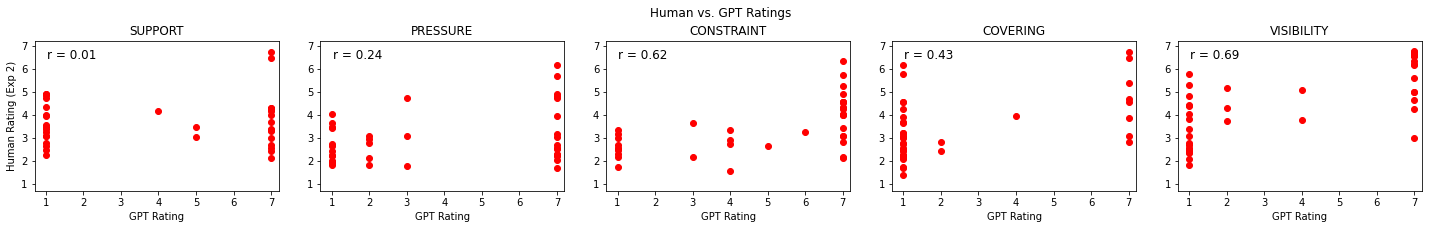

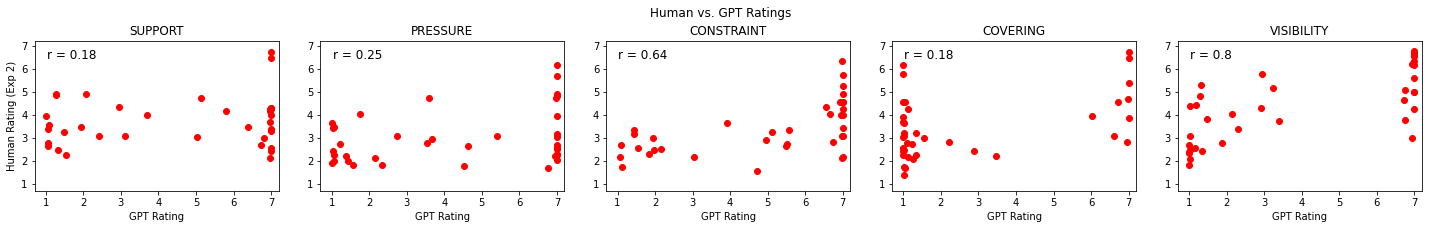

In [32]:
make_scatter_plots_beitel(model_result_dict_2=davinci003_exp2_dict, title="Human vs. GPT Ratings") 
make_scatter_plots_beitel(model_result_dict_2=davinci003_exp2_dict_logprobs, title="Human vs. GPT Ratings") 

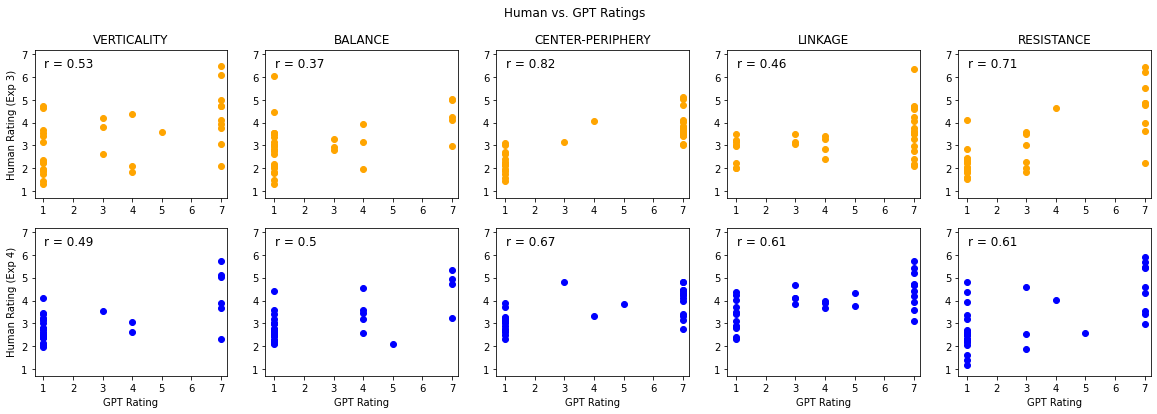

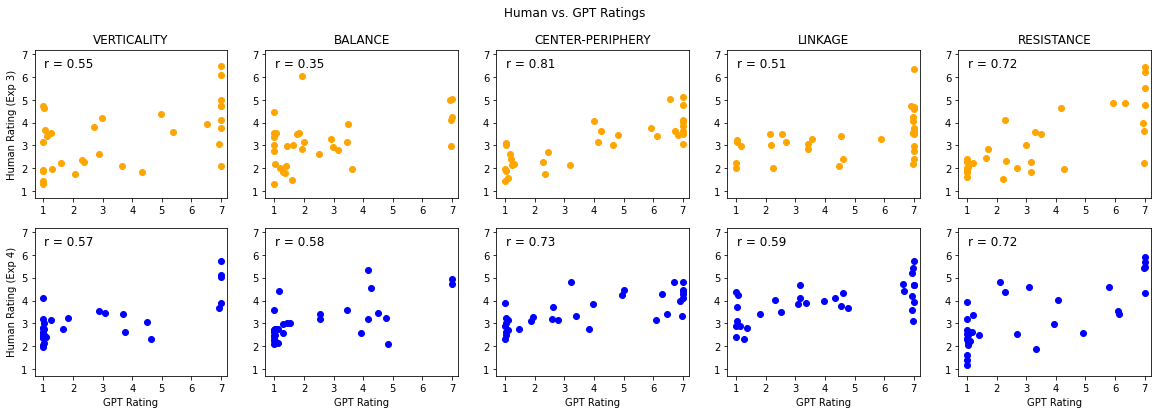

In [33]:
make_scatter_plots_gibbs(model_result_dict_3=davinci003_exp3_dict, model_result_dict_4=davinci003_exp4_dict, title="Human vs. GPT Ratings") 
make_scatter_plots_gibbs(model_result_dict_3=davinci003_exp3_dict_logprobs, model_result_dict_4=davinci003_exp4_dict_logprobs, title="Human vs. GPT Ratings") 

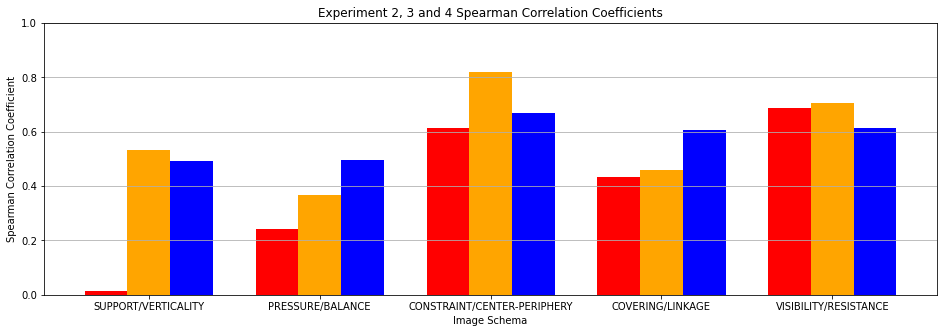

In [34]:
make_bar_plots_all(model_result_dict_2=davinci003_exp2_dict, model_result_dict_3=davinci003_exp3_dict, model_result_dict_4=davinci003_exp4_dict, title="Experiment 2, 3 and 4 Spearman Correlation Coefficients")